# 基于CNN的CIFAR-10 分类

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import math
# 设置随机种子以确保结果可重复
torch.manual_seed(42)
if torch.cuda.is_available():
    print('CUDA is available')
    torch.cuda.manual_seed_all(42)
else:
    print('CUDA is not available')

CUDA is available


In [ ]:
# ========== 1. 数据加载与预处理 ==========
# 定义数据转换操作
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转，数据增强
    transforms.RandomRotation(15),      # 随机旋转，数据增强
    transforms.ToTensor(),              # 转换为张量并归一化到[0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化到[-1,1]
])



transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 下载CIFAR-10数据集
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# 类别标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [65]:
# ========== 2. 模型定义 ==========
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 输入通道3，输出通道32，卷积核3x3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # 池化层
        self.pool = nn.MaxPool2d(2, 2)
        
        # 全连接层
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 输入特征数由卷积层输出计算得出
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # 输出类别数为10
        
        # Dropout层用于防止过拟合
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # 卷积 + 激活 + 池化
        x = self.pool(F.relu(self.conv1(x)))  # 输出大小: (32, 16, 16)
        x = self.pool(F.relu(self.conv2(x)))  # 输出大小: (64, 8, 8)
        x = self.pool(F.relu(self.conv3(x)))  # 输出大小: (128, 4, 4)
        
        # 展平
        x = x.view(-1, 128 * 4 * 4)  # 展平为一维向量
        
        # 全连接层 + Dropout + 激活
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)  # 输出层不加激活函数，因为使用交叉熵损失函数
        
        return x

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("use",device)
model = CNN().to(device)

use cuda


In [66]:
# ========== 3. 损失函数和优化器 ==========
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类任务
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器，学习率0.001

In [67]:

# ========== 4. 训练函数 ==========
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # 将数据移动到设备上
        
        optimizer.zero_grad()  # 清空梯度
        
        output = model(data)  # 前向传播
        loss = criterion(output, target)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_loss += loss.item()
        _, predicted = output.max(1)  # 获取预测类别
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # 每100个批次打印一次训练状态
        if batch_idx % 100 == 99:
            print(f'Epoch: {epoch+1} [{batch_idx+1}/{len(train_loader)}] '
                  f'Loss: {running_loss / (batch_idx+1):.4f} '
                  f'Acc: {100. * correct / total:.2f}%')
    
    # 计算整个epoch的平均损失和准确率
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [68]:

# ========== 5. 测试函数 ==========
def test(model, device, test_loader, criterion):
    model.eval()  # 设置模型为评估模式
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 禁用梯度计算
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += criterion(output, target).item()  # 累加损失
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%')
    return test_loss, test_acc


In [69]:

# ========== 6. 可视化函数 ==========
def visualize_results(train_losses, train_accs, test_losses, test_accs):
    # 绘制训练和测试损失
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 绘制训练和测试准确率
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [70]:

# ========== 可视化==========
train_losses, train_accs = [], []
def imshow(images, predictions, probabilities, labels):
    # 反标准化
    images = images / 2 + 0.5  # 反标准化
    npimages = images.numpy()  # 转换为NumPy数组

    # 获取图片数量
    num_images = len(images)
    
    # 动态计算子图的行数和列数
    cols = 8  # 每行最多显示8张图片
    rows = math.ceil(num_images / cols)  # 向上取整

    # 创建图形和子图
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 3 * rows), dpi=200)  # 动态调整图形大小
    plt.subplots_adjust(wspace=0.2, hspace=0.2)  # 调整子图之间的间隔

    # 如果只有一行，确保axes是一个二维数组
    if rows == 1:
        axes = axes.reshape(1, -1)

    # 遍历所有图片
    for i in range(num_images):
        row = i // cols  # 计算当前图片所在的行
        col = i % cols   # 计算当前图片所在的列

        # 显示图像
        axes[row, col].imshow(np.transpose(npimages[i], (1, 2, 0)), interpolation='nearest')  # 使用最近邻插值
        axes[row, col].axis('off')  # 关闭坐标轴

        # 显示预测结果和可信度
        predicted = classes[predictions[i]]
        confidence = probabilities[i][predictions[i]]  # 获取预测类别的概率
        # 在图像上方添加预测结果文字
        axes[row, col].text(0.5, -0.15, f'{predicted} ({confidence:.2f})', horizontalalignment='center',
                            verticalalignment='center', transform=axes[row, col].transAxes,
                            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # 隐藏多余的子图
    for i in range(num_images, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')  # 关闭多余的子图

    plt.show()



Epoch 1/20
Epoch: 1 [100/782] Loss: 2.1166 Acc: 18.97%
Epoch: 1 [200/782] Loss: 1.9728 Acc: 25.10%
Epoch: 1 [300/782] Loss: 1.8867 Acc: 28.78%
Epoch: 1 [400/782] Loss: 1.8099 Acc: 32.18%
Epoch: 1 [500/782] Loss: 1.7568 Acc: 34.27%
Epoch: 1 [600/782] Loss: 1.7112 Acc: 36.16%
Epoch: 1 [700/782] Loss: 1.6753 Acc: 37.70%
Test set: Average loss: 1.2876, Accuracy: 52.68%

Epoch 2/20
Epoch: 2 [100/782] Loss: 1.3806 Acc: 49.09%
Epoch: 2 [200/782] Loss: 1.3740 Acc: 49.52%
Epoch: 2 [300/782] Loss: 1.3643 Acc: 50.02%
Epoch: 2 [400/782] Loss: 1.3502 Acc: 50.79%
Epoch: 2 [500/782] Loss: 1.3391 Acc: 51.25%
Epoch: 2 [600/782] Loss: 1.3290 Acc: 51.72%
Epoch: 2 [700/782] Loss: 1.3168 Acc: 52.21%
Test set: Average loss: 1.1087, Accuracy: 59.79%

Epoch 3/20
Epoch: 3 [100/782] Loss: 1.1923 Acc: 57.17%
Epoch: 3 [200/782] Loss: 1.1942 Acc: 57.10%
Epoch: 3 [300/782] Loss: 1.1923 Acc: 57.31%
Epoch: 3 [400/782] Loss: 1.1923 Acc: 57.29%
Epoch: 3 [500/782] Loss: 1.1884 Acc: 57.49%
Epoch: 3 [600/782] Loss: 1.181

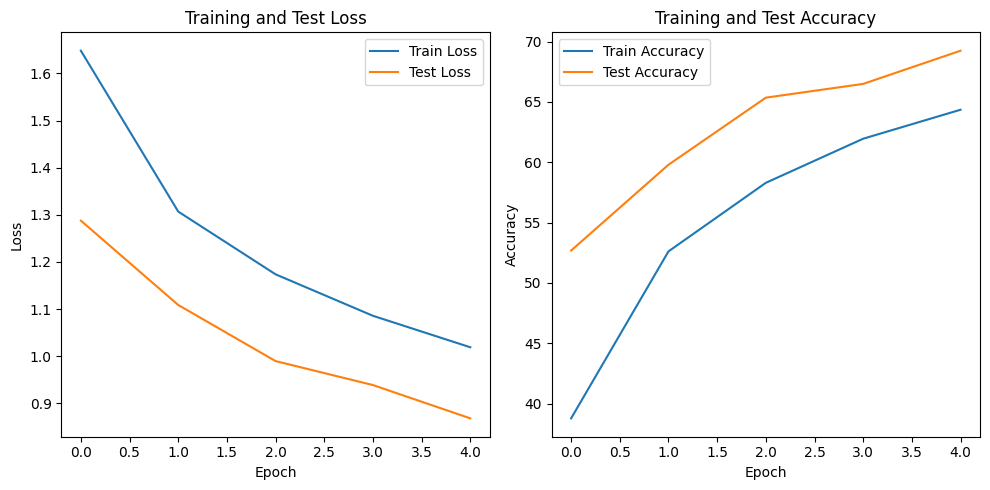


Epoch 6/20
Epoch: 6 [100/782] Loss: 0.9845 Acc: 65.91%
Epoch: 6 [200/782] Loss: 0.9713 Acc: 66.34%
Epoch: 6 [300/782] Loss: 0.9711 Acc: 66.20%
Epoch: 6 [400/782] Loss: 0.9740 Acc: 66.11%
Epoch: 6 [500/782] Loss: 0.9755 Acc: 66.14%
Epoch: 6 [600/782] Loss: 0.9748 Acc: 66.15%
Epoch: 6 [700/782] Loss: 0.9702 Acc: 66.32%
Test set: Average loss: 0.8187, Accuracy: 71.83%

Epoch 7/20
Epoch: 7 [100/782] Loss: 0.9410 Acc: 67.70%
Epoch: 7 [200/782] Loss: 0.9332 Acc: 67.77%
Epoch: 7 [300/782] Loss: 0.9325 Acc: 67.79%
Epoch: 7 [400/782] Loss: 0.9400 Acc: 67.66%
Epoch: 7 [500/782] Loss: 0.9403 Acc: 67.56%
Epoch: 7 [600/782] Loss: 0.9394 Acc: 67.46%
Epoch: 7 [700/782] Loss: 0.9349 Acc: 67.65%
Test set: Average loss: 0.7976, Accuracy: 72.56%

Epoch 8/20
Epoch: 8 [100/782] Loss: 0.8958 Acc: 68.56%
Epoch: 8 [200/782] Loss: 0.8884 Acc: 69.00%
Epoch: 8 [300/782] Loss: 0.8923 Acc: 68.93%
Epoch: 8 [400/782] Loss: 0.8988 Acc: 68.59%
Epoch: 8 [500/782] Loss: 0.9003 Acc: 68.58%
Epoch: 8 [600/782] Loss: 0.902

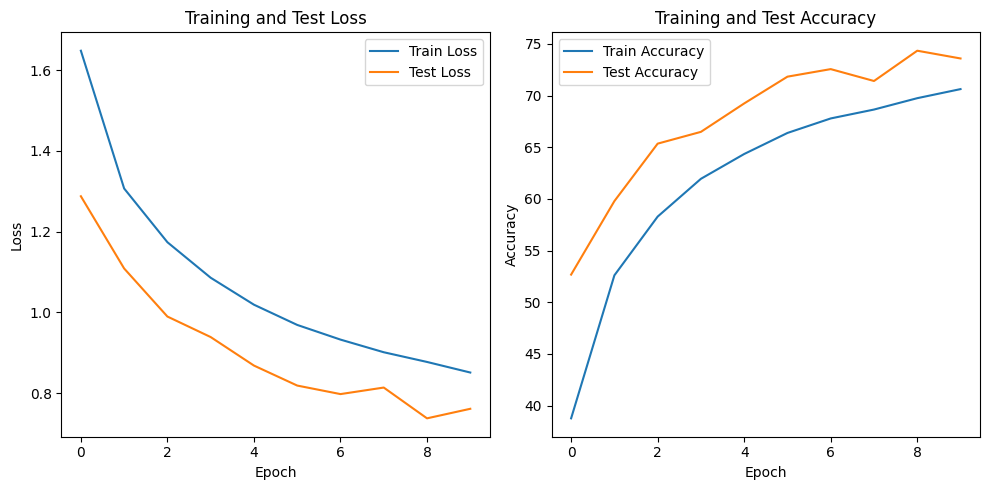


Epoch 11/20
Epoch: 11 [100/782] Loss: 0.8272 Acc: 71.30%
Epoch: 11 [200/782] Loss: 0.8252 Acc: 71.40%
Epoch: 11 [300/782] Loss: 0.8248 Acc: 71.62%
Epoch: 11 [400/782] Loss: 0.8270 Acc: 71.56%
Epoch: 11 [500/782] Loss: 0.8352 Acc: 71.21%
Epoch: 11 [600/782] Loss: 0.8375 Acc: 71.21%
Epoch: 11 [700/782] Loss: 0.8402 Acc: 71.26%
Test set: Average loss: 0.7319, Accuracy: 74.42%

Epoch 12/20
Epoch: 12 [100/782] Loss: 0.8263 Acc: 71.20%
Epoch: 12 [200/782] Loss: 0.8129 Acc: 71.72%
Epoch: 12 [300/782] Loss: 0.8160 Acc: 71.82%
Epoch: 12 [400/782] Loss: 0.8170 Acc: 71.76%
Epoch: 12 [500/782] Loss: 0.8216 Acc: 71.61%
Epoch: 12 [600/782] Loss: 0.8264 Acc: 71.40%
Epoch: 12 [700/782] Loss: 0.8307 Acc: 71.23%
Test set: Average loss: 0.7387, Accuracy: 74.60%

Epoch 13/20
Epoch: 13 [100/782] Loss: 0.7878 Acc: 72.81%
Epoch: 13 [200/782] Loss: 0.8097 Acc: 72.10%
Epoch: 13 [300/782] Loss: 0.8029 Acc: 72.31%
Epoch: 13 [400/782] Loss: 0.8073 Acc: 72.16%
Epoch: 13 [500/782] Loss: 0.8087 Acc: 72.08%
Epoch: 1

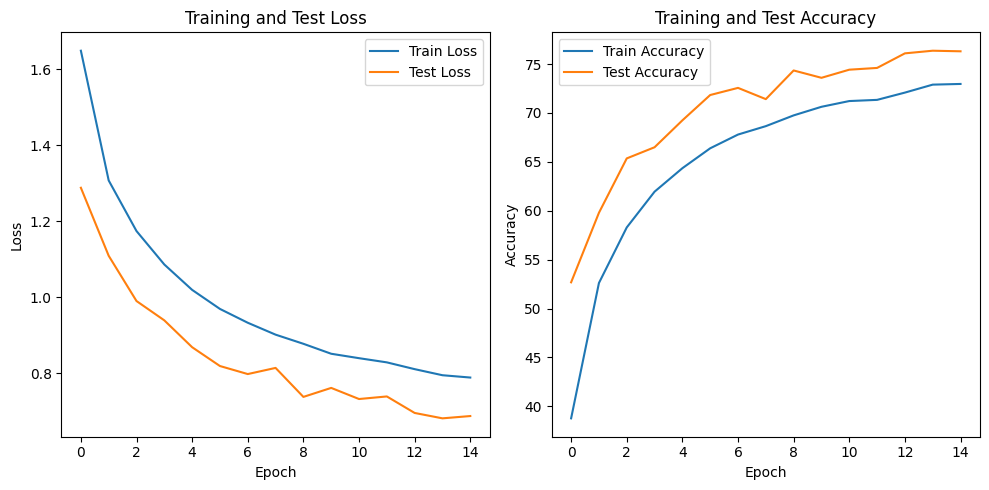


Epoch 16/20
Epoch: 16 [100/782] Loss: 0.7587 Acc: 73.34%
Epoch: 16 [200/782] Loss: 0.7542 Acc: 73.70%
Epoch: 16 [300/782] Loss: 0.7564 Acc: 73.83%
Epoch: 16 [400/782] Loss: 0.7635 Acc: 73.76%
Epoch: 16 [500/782] Loss: 0.7726 Acc: 73.64%
Epoch: 16 [600/782] Loss: 0.7712 Acc: 73.55%
Epoch: 16 [700/782] Loss: 0.7711 Acc: 73.66%
Test set: Average loss: 0.6835, Accuracy: 76.67%

Epoch 17/20
Epoch: 17 [100/782] Loss: 0.7550 Acc: 74.00%
Epoch: 17 [200/782] Loss: 0.7685 Acc: 73.86%
Epoch: 17 [300/782] Loss: 0.7667 Acc: 74.01%
Epoch: 17 [400/782] Loss: 0.7770 Acc: 73.66%
Epoch: 17 [500/782] Loss: 0.7705 Acc: 73.94%
Epoch: 17 [600/782] Loss: 0.7703 Acc: 73.91%
Epoch: 17 [700/782] Loss: 0.7732 Acc: 73.80%
Test set: Average loss: 0.6640, Accuracy: 77.02%

Epoch 18/20
Epoch: 18 [100/782] Loss: 0.7492 Acc: 74.33%
Epoch: 18 [200/782] Loss: 0.7466 Acc: 74.48%
Epoch: 18 [300/782] Loss: 0.7510 Acc: 74.44%
Epoch: 18 [400/782] Loss: 0.7528 Acc: 74.34%
Epoch: 18 [500/782] Loss: 0.7554 Acc: 74.23%
Epoch: 1

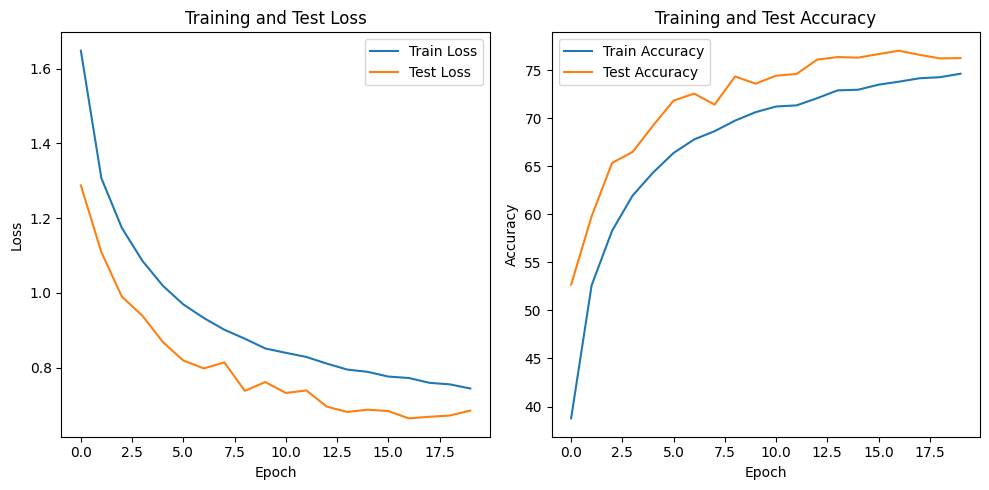

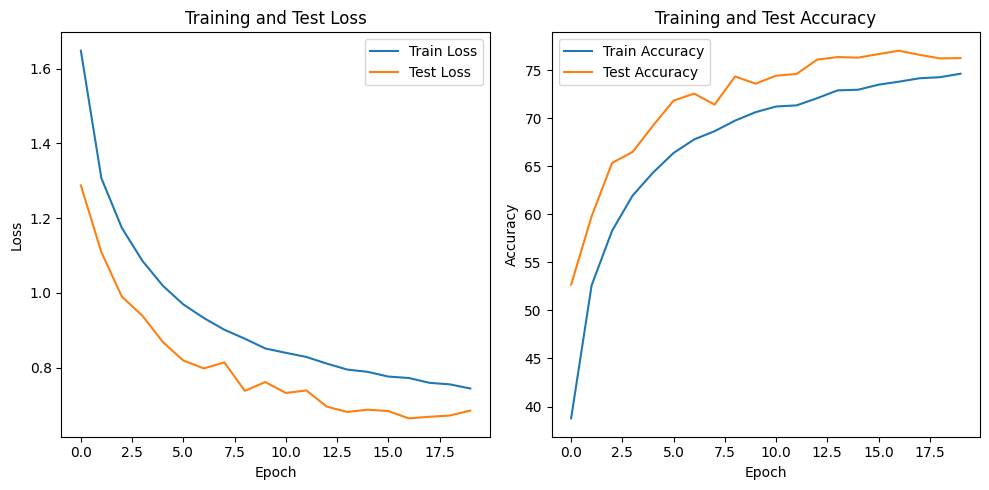

ValueError: too many values to unpack (expected 2)

In [ ]:

# ========== 7. 主训练循环 ==========


num_epochs = 20
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    # 训练一个epoch
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # 测试一个epoch
    test_loss, test_acc = test(model, device, test_loader, criterion)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # 可视化中间结果（每5个epoch）
    if (epoch+1) % 5 == 0:
        visualize_results(train_losses, train_accs, test_losses, test_accs)

# 最终可视化
visualize_results(train_losses, train_accs, test_losses, test_accs)

# ========== 8. 模型预测示例 ==========
def predict_image(model, device, image):
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 禁用梯度计算
        image = image.to(device)
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)  # 计算概率
        _, predicted = output.max(1)  # 获取预测类别
    return predicted.cpu().numpy(), probabilities.cpu().numpy()

# 获取一批测试数据
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# 预测
predictions,probabilities = predict_image(model, device, images)


# 显示图像和预测结果
imshow(images, predictions, probabilities, labels.numpy())
# imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{classes[predictions[j]]:5s}' for j in range(4)))

# ========== 9. 模型保存与加载 ==========
# 保存模型
torch.save(model.state_dict(), 'new_cifar10_cnn.pth')

# 加载模型
# model = CNN().to(device)
# model.load_state_dict(torch.load('cifar10_cnn.pth'))

# ========== 10. 模型调优建议 ==========
"""
以下是进一步调优的建议：
1. 调整学习率：尝试不同的学习率（如0.0001, 0.001, 0.01）观察效果
2. 增加模型深度：添加更多卷积层或使用预训练模型（如ResNet）
3. 调整数据增强：尝试不同的数据增强策略（如随机裁剪、颜色抖动等）
4. 调整Dropout率：尝试不同的Dropout概率（如0.3, 0.5, 0.6）
5. 尝试不同的优化器：如SGD + 动量，RMSprop等
6. 使用学习率调度器：动态调整学习率
7. 增加正则化：如L2正则化（weight decay）
8. 调整批量大小：尝试不同的batch size
"""

# ========== 11. 学习率调度器示例 ==========
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# 在每个epoch后调用scheduler.step()